## Настройки/Гиперпараметры/Импорты

In [1]:
import sys

sys.path.append("./models/GLDAW/")

In [2]:
import numpy as np
import pandas as pd
import math
import psutil
from pandarallel import pandarallel
from tqdm import tqdm

import gibbslda

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import time

In [3]:
print('Количество доступных потоков: ', psutil.cpu_count(logical=False)) # число доступных топоков

Количество доступных потоков:  4


### 1) Очистка данных

In [4]:
dataset = pd.read_csv("./data/The Guardian_example_1.csv", sep=";", encoding="ANSI")
dataset

,Section,Headline,Content,Publication Date,URL
0,World news,Russia expels Dutch journalist Tom Vennink,Russia has expelled a Dutch reporter his news...,2021-11-04 11:11:36,https://www.theguardian.com/world/2021/nov/04/...
1,Science,Can you solve it? From Russia with logic,The largest and most important event in the ma...,2021-12-13 07:10:01,https://www.theguardian.com/science/2021/dec/1...
2,Science,Did you solve it? From Russia with logic,Earlier today I set you three questions from a...,2021-12-13 17:00:24,https://www.theguardian.com/science/2021/dec/1...
3,Politics,Labour challenges Tories over checks on Russia...,Labour has asked the Conservatives what checks...,2021-11-17 13:04:29,https://www.theguardian.com/politics/2021/nov/...
4,World news,Russia holds high-profile Afghanistan talks wi...,Russia has hosted the most high-profile intern...,2021-10-20 17:09:40,https://www.theguardian.com/world/2021/oct/20/...
...,...,...,...,...,...
2548,US news,Trump impeachment trial to begin week of 8 Feb...,From me and Joan E Greve: Senate leader Chuck ...,2021-01-23 01:08:03,https://www.theguardian.com/us-news/live/2021/...
2549,World news,France's Covid toll passes 70 000 – as it happ...,We are closing this blog now and starting fre...,2021-01-17 00:53:34,https://www.theguardian.com/world/live/2021/ja...
2550,World news,EU 'to stop short of vaccine export ban' – as ...,We’ve launched a new blog at the link below – ...,2021-01-26 23:34:50,https://www.theguardian.com/world/live/2021/ja...
2551,World news,Pandemic death toll exceeds 2 million people w...,This liveblog has now closed. Our coverage of ...,2021-01-15 21:30:06,https://www.theguardian.com/world/live/2021/ja...


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2553 entries, 0 to 2552
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Section           2553 non-null   object
 1   Headline          2553 non-null   object
 2   Content           2553 non-null   object
 3   Publication Date  2553 non-null   object
 4   URL               2553 non-null   object
dtypes: object(5)
memory usage: 99.9+ KB


In [6]:
dataset.describe()

,Section,Headline,Content,Publication Date,URL
count,2553,2553,2553,2553,2553
unique,39,2526,2535,2513,2535
top,World news,Corrections and clarifications,You may have heard this one before. It was noi...,2021-08-18 14:22:22,https://www.theguardian.com/football/2021/jun/...
freq,867,10,2,2,2


In [7]:
dataset["Section"].value_counts()

Section
World news                867
Football                  235
US news                   234
Opinion                   190
Sport                     166
Environment               150
Business                  100
Australia news             85
Politics                   76
Books                      68
Television & radio         44
UK news                    38
Technology                 33
News                       31
Science                    31
Film                       30
Art and design             23
Life and style             22
Global development         21
Media                      20
Society                    17
Music                      16
Stage                      10
Culture                     9
Travel                      7
Education                   6
Law                         6
Money                       3
Membership                  2
From the Observer           2
Global                      2
Info                        2
Guardian Careers            1
In

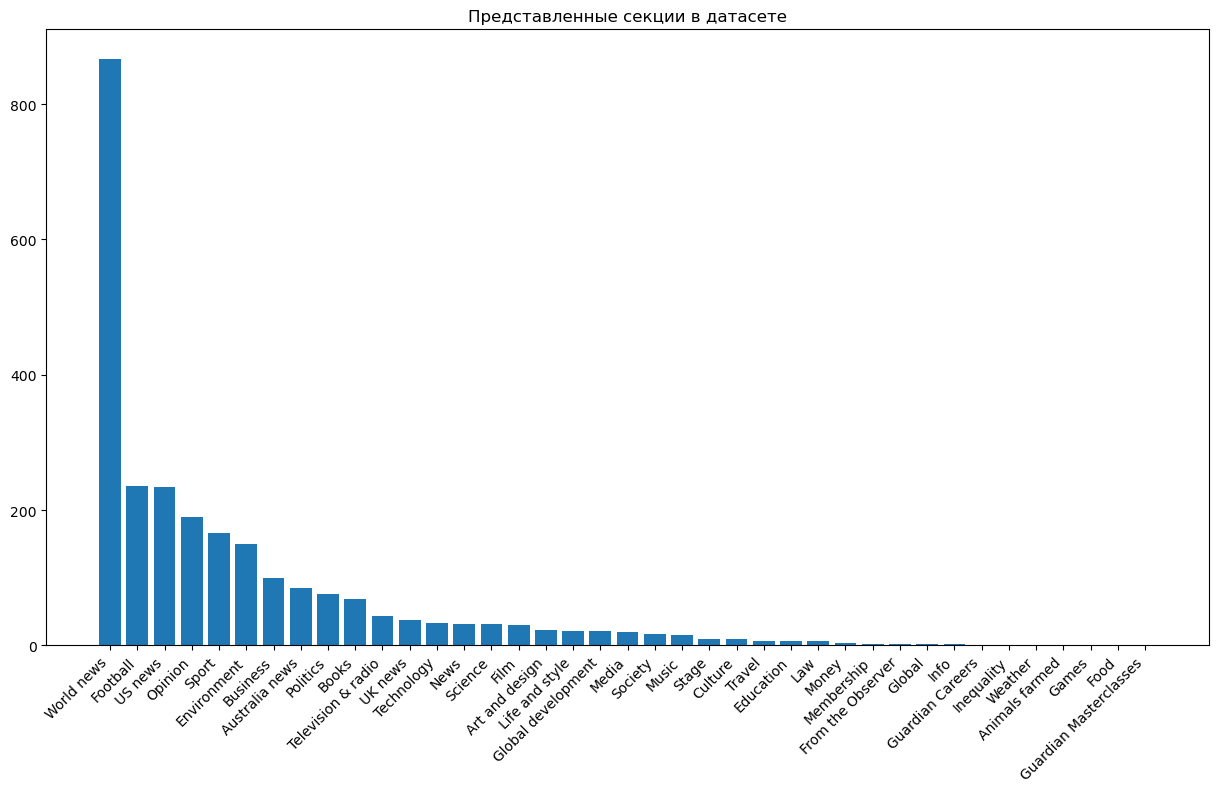

In [8]:
plt.figure(figsize=(15,8))
plt.bar(dataset["Section"].value_counts().index, dataset["Section"].value_counts())
plt.xticks(rotation=45, ha='right')
plt.title("Представленные секции в датасете")
plt.show()

In [9]:
pandarallel.initialize(progress_bar=True)

def clear_data(df: pd.DataFrame, column, variant) -> pd.DataFrame:
    import re
    from nltk.tokenize import word_tokenize
    stop_words = stopwords.words('english')
    
    lemmatizer = WordNetLemmatizer()
    df[column] = df[column].parallel_apply(lambda text: text.lower())
    
    if variant == 'http' or variant == 'all':
        df[column] = df[column].parallel_apply(lambda text: re.sub("http\S*", ' ', text))
    
    if variant == 'punct' or variant == 'all':
        df[column] = df[column].parallel_apply(lambda text: re.sub(r"[,.…?:;¦/\\!@#$#—+=ツ►๑۞۩•«»“”˜°*`\"'™)(<>\[\]%$&]", '', text))
        df[column] = df[column].parallel_apply(lambda text: re.sub("-", ' ', text))
    
    df[column] = df[column].parallel_apply(lambda text: word_tokenize(text))
    df[column] = df[column].parallel_apply(lambda text: [lemmatizer.lemmatize(word) for word in text])
    
    if variant == 'stop words' or variant == 'all':
        df[column] = df[column].parallel_apply(lambda text: [word for word in text if word not in stop_words])
    
    df[column] = df[column].parallel_apply(lambda text: ' '.join(text))
    df[column] = df[column].astype('string')
    df = df[df[column] != ""]
    df.reset_index(drop=True, inplace=True)
    return df

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [10]:
dataset_cleared_all = clear_data(dataset.copy(), "Content", 'all')

In [11]:
dataset_cleared_all

,Section,Headline,Content,Publication Date,URL
0,World news,Russia expels Dutch journalist Tom Vennink,russia ha expelled dutch reporter newspaper ha...,2021-11-04 11:11:36,https://www.theguardian.com/world/2021/nov/04/...
1,Science,Can you solve it? From Russia with logic,largest important event mathematical calendar ...,2021-12-13 07:10:01,https://www.theguardian.com/science/2021/dec/1...
2,Science,Did you solve it? From Russia with logic,earlier today set three question russian math ...,2021-12-13 17:00:24,https://www.theguardian.com/science/2021/dec/1...
3,Politics,Labour challenges Tories over checks on Russia...,labour ha asked conservative check party ha ma...,2021-11-17 13:04:29,https://www.theguardian.com/politics/2021/nov/...
4,World news,Russia holds high-profile Afghanistan talks wi...,russia ha hosted high profile international ta...,2021-10-20 17:09:40,https://www.theguardian.com/world/2021/oct/20/...
...,...,...,...,...,...
2548,US news,Trump impeachment trial to begin week of 8 Feb...,joan e greve senate leader chuck schumer ha an...,2021-01-23 01:08:03,https://www.theguardian.com/us-news/live/2021/...
2549,World news,France's Covid toll passes 70 000 – as it happ...,closing blog starting fresh australia ’ health...,2021-01-17 00:53:34,https://www.theguardian.com/world/live/2021/ja...
2550,World news,EU 'to stop short of vaccine export ban' – as ...,’ launched new blog link – head latest hotel q...,2021-01-26 23:34:50,https://www.theguardian.com/world/live/2021/ja...
2551,World news,Pandemic death toll exceeds 2 million people w...,liveblog ha closed coverage coronavirus pandem...,2021-01-15 21:30:06,https://www.theguardian.com/world/live/2021/ja...


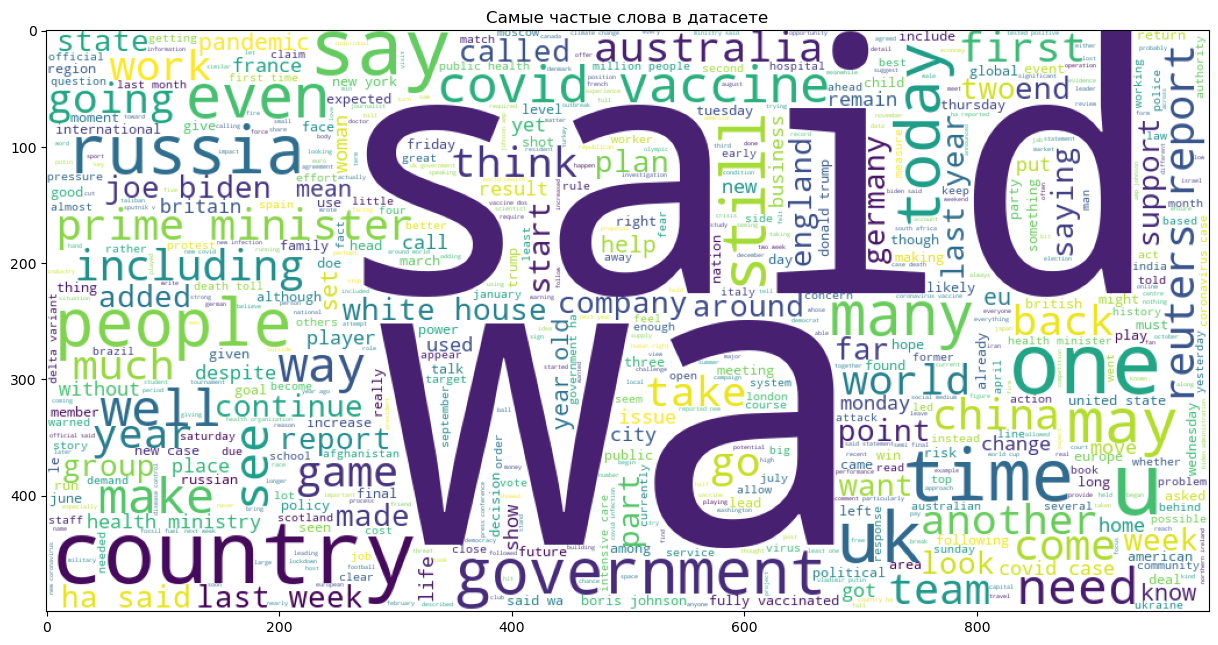

In [12]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', width=1000, height=500, random_state=42)
wordcloud.generate(" ".join(dataset_cleared_all["Content"]))

plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.title("Самые частые слова в датасете")
plt.show()

### 2) эмбединги

In [13]:
corpus = [doc.split() for doc in dataset_cleared_all["Content"]]
print(corpus[:2])

[['russia', 'ha', 'expelled', 'dutch', 'reporter', 'newspaper', 'ha', 'said', 'moscow', 'continues', 'crackdown', 'domestic', 'foreign', 'journalist', 'country', 'de', 'volkskrant', 'journalist', 'tom', 'vennink', 'said', 'visa', 'wa', 'revoked', 'wa', 'given', 'three', 'day', 'leave', 'country', 'difficulty', 'renewing', 'journalist', 'accreditation', 'expulsion', 'second', 'foreign', 'journalist', 'recent', 'month', 'following', 'russia', '’', 'decision', 'august', 'ban', 'bbc', 'reporter', 'sarah', 'rainsford', 'country', 'security', 'threat', 'formally', 'vennink', 'wa', 'targeted', 'russia', '’', 'interior', 'ministry', 'two', 'minor', 'administrative', 'violation', 'including', 'failure', 'register', 'temporary', 'address', 'dating', 'back', '2019', 'increasingly', 'bitter', 'relationship', 'moscow', 'amsterdam', 'appears', 'played', 'role', 'decision', 'vennink', 'respected', 'foreign', 'correspondent', 'ha', 'reported', 'russia', 'since', '2015', 'said', 'expulsion', 'came', 's

In [14]:
unique_words = set()

for doc in corpus:
    for word in doc:
        unique_words.add(word)

print(f"Число слов в датасете: {len(unique_words)}")

Число слов в датасете: 68100


In [43]:
vectors = {}

with open("./embeddings/wiki-news-300d-1M-subword.vec", "r", encoding="utf-8") as f:
    _ = f.readline()
    for line in tqdm(f):
        tokens = line.split()
        if tokens[0] in unique_words and len(unique_words):
            vectors[tokens[0]] = map(float, tokens[1:])
            vectors[tokens[0]] = list(vectors[tokens[0]])
pd.DataFrame(vectors)

999994it [00:31, 31501.37it/s]


,one,|,page,also,time,people,like,article,would,talk,...,trapp,dartford,kwik,hippogriffs,umra,empt,pch,bootle,gerson,steinberg
0,0.0104,0.0247,0.0089,-0.0084,-0.0032,0.0089,0.0045,0.0050,-0.0107,0.0212,...,0.0021,0.0029,0.0005,-0.0155,-0.0377,-0.0001,-0.0021,-0.0008,0.0015,0.0007
1,0.0027,0.0284,-0.0544,-0.0032,-0.0722,-0.0051,0.0068,-0.0114,0.0047,-0.0325,...,-0.0164,-0.0274,0.0084,-0.0092,-0.0070,-0.0028,0.0002,-0.0075,-0.0080,-0.0098
2,0.0131,0.0351,0.0387,0.0216,0.0054,0.0078,0.0316,0.0150,0.0067,0.0039,...,0.0041,-0.0122,0.0035,0.0095,0.0036,-0.0026,-0.0000,-0.0023,-0.0080,0.0038
3,-0.0020,0.0565,0.0045,-0.0193,0.0051,0.0004,0.0096,0.0046,0.0066,0.0009,...,0.0134,-0.0045,-0.0041,-0.0010,-0.0183,0.0025,0.0048,0.0272,0.0063,0.0098
4,-0.0282,-0.0541,0.0548,-0.0046,0.0142,-0.0121,-0.0098,0.0234,-0.0017,-0.0031,...,0.0008,-0.0063,-0.0032,-0.0087,0.0060,0.0068,0.0053,-0.0033,0.0015,0.0033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0019,-0.0401,0.0113,0.0128,0.0275,0.0167,0.0130,-0.0055,-0.0083,-0.0188,...,-0.0269,-0.0099,-0.0089,0.0006,0.0241,-0.0257,0.0060,-0.0090,0.0061,-0.0070
296,0.0250,-0.0019,-0.0072,-0.0005,-0.0083,0.0132,0.0099,0.0037,-0.0095,0.0018,...,0.0120,-0.0074,0.0045,0.0111,0.0433,-0.0224,-0.0001,-0.0068,-0.0004,0.0049
297,0.0195,0.0389,0.0097,0.0086,-0.0151,-0.0107,0.0122,-0.0015,0.0005,-0.0085,...,0.0126,-0.0120,-0.0008,0.0224,0.0096,-0.0205,-0.0145,-0.0054,0.0072,0.0080
298,0.0267,0.0415,0.0053,0.0169,-0.0035,-0.0224,0.0049,-0.0138,-0.0072,0.0002,...,0.0327,-0.0059,0.0082,-0.0213,-0.0007,-0.0042,0.0090,-0.0123,-0.0123,-0.0110


In [39]:
with open("./embeddings/words_in_docs.txt", "w") as f:
    for word in vectors.keys():
        vector = map(str, vectors[word])
        vector = list(vector)
        f.write(f"{word} {' '.join(vector)}\n")

### 3) определение количества тем

In [20]:
model = gibbslda.CGibbsLDA()
model

In [21]:
model.SetInputDocs(corpus)

Documents count:  2553
Loading OK     


In [22]:
model.SetParameters(alpha=0.1, beta=0.1, topics=200, niters=100, nitersave=100, ldamethod="embeddings", fixtopics=0, granwnd=0, out_dir=f"./data/100_topics/")
model.SetEmbeddings("./embeddings/words_in_docs.txt", emb_similars=30)

Calculating the Most Similar Words
Done. Words misses =  27433 / 68100


In [18]:
start_time = time.time()

model.StartCalculation()

print(f"Время, затраченное на нахождение {200} тем: {time.time() - start_time:.5f} секунд")

Iterations done:  100
    Documents ratio (Theta) =  3
    Words ratio (Phi) =  1
Время, затраченное на нахождение 200 тем: 317.62327 секунд


In [24]:
Ф_columns = ["Word"]
Ф_columns.extend([f"Topic {i+1}" for i in range(200)])
Ф = pd.read_csv("./data/100_topics/phi100.csv", sep=";", encoding="UTF-8", index_col=False, names=Ф_columns)
Ф

,Word,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 191,Topic 192,Topic 193,Topic 194,Topic 195,Topic 196,Topic 197,Topic 198,Topic 199,Topic 200
0,1988,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,...,0.00005,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00000,0.00000,0.00001
1,200,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,...,0.00004,0.00001,0.00001,0.00001,0.00015,0.00001,0.00001,0.00000,0.00022,0.00001
2,2011,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,...,0.00036,0.00001,0.00001,0.00137,0.00001,0.00001,0.00001,0.00011,0.00000,0.00001
3,2014,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,...,0.00107,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00060,0.00000,0.00001
4,2015,0.00016,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,...,0.00034,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00032,0.00000,0.00001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68095,thawley,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,...,0.00000,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00000,0.00000,0.00001
68096,transportable,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,...,0.00000,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00000,0.00000,0.00001
68097,trashy,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,...,0.00000,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00000,0.00000,0.00001
68098,vaccinecovid,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,...,0.00000,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00000,0.00000,0.00001


In [25]:
Θ_columns = ["Doc"]
Θ_columns.extend([f"Topic {i+1}" for i in range(200)])
Θ = pd.read_csv("./data/100_topics/theta100.csv", sep=";", encoding="UTF-8", index_col=0, names=Θ_columns)
Θ

,Doc,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 191,Topic 192,Topic 193,Topic 194,Topic 195,Topic 196,Topic 197,Topic 198,Topic 199,Topic 200
1,russia ha expelled dutch reporter newspaper ha...,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,...,0.77297,0.00024,0.00024,0.00024,0.00742,0.00024,0.00024,0.10550,0.00024,0.00024
2,largest important event mathematical calendar ...,0.00031,0.00031,0.00031,0.00031,0.00031,0.00031,0.00031,0.00031,0.00031,...,0.00031,0.00031,0.00031,0.00031,0.00031,0.00031,0.00031,0.00652,0.07484,0.00652
3,earlier today set three question russian math ...,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,...,0.00260,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.03333,0.00024
4,labour ha asked conservative check party ha ma...,0.00020,0.00020,0.00020,0.00020,0.00020,0.00020,0.00020,0.00020,0.00020,...,0.38665,0.00020,0.00020,0.00020,0.00020,0.00020,0.00020,0.00020,0.02012,0.00020
5,russia ha hosted high profile international ta...,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021,...,0.12283,0.00233,0.00021,0.00021,0.00021,0.00021,0.00021,0.24757,0.06998,0.00021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2549,joan e greve senate leader chuck schumer ha an...,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,...,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00213,0.08562,0.00003
2550,closing blog starting fresh australia ’ health...,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00032,...,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.60253,0.00003
2551,’ launched new blog link – head latest hotel q...,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,...,0.01339,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.02008,0.50991,0.00003
2552,liveblog ha closed coverage coronavirus pandem...,0.00032,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,...,0.00003,0.00003,0.00003,0.00003,0.00003,0.00061,0.00003,0.00003,0.56607,0.00003


In [26]:
del Ф['Word']

X = Ф.values
num_words, num_topics = X.shape
print('Число слов: ', num_words)
print('Число тем: ', num_topics)

X[X < 0.00000001] = 0.00000001
X

Число слов:  68100
Число тем:  200


array([[1.0e-05, 1.0e-05, 1.0e-05, ..., 1.0e-08, 1.0e-08, 1.0e-05],
       [1.0e-05, 1.0e-05, 1.0e-05, ..., 1.0e-08, 2.2e-04, 1.0e-05],
       [1.0e-05, 1.0e-05, 1.0e-05, ..., 1.1e-04, 1.0e-08, 1.0e-05],
       ...,
       [1.0e-05, 1.0e-05, 1.0e-05, ..., 1.0e-08, 1.0e-08, 1.0e-05],
       [1.0e-05, 1.0e-05, 1.0e-05, ..., 1.0e-08, 1.0e-08, 1.0e-05],
       [1.0e-05, 1.0e-05, 1.0e-05, ..., 1.0e-08, 1.0e-08, 1.0e-05]])

In [27]:
num_words, num_topics = X.shape
print(f"Количество тем в начале: {num_topics}")

threshold = 1/num_words
min_Renyi = 1000000000
opt_topics_count = num_topics
Density = []
Energy = []

glob_Renyi = []
glob_clusters = []

renorm_iter = num_topics - 1

start = time.time()
for r in range(renorm_iter):
    num_words, num_topics = X.shape
    print(f"Текущее количество тем: {num_topics}")
    Renyi = []
    clusters = []
    xc = 0
    xs = []
    glob_word_ratio = 0
    glob_sum_prob = 0
    glob_free_energy = 0
    glob_Renyi_entropy = 0
    
    for topic_id in range(num_topics):
        word_ratio = 0
        word_ratio_n = 0
        sum_prob = 0
        free_energy = 0
        Renyi_entropy = 0
        
        for word_id in range(num_words):
            if X[word_id][topic_id] > threshold:
                sum_prob = sum_prob + X[word_id][topic_id]
                word_ratio = word_ratio + 1
                glob_sum_prob = glob_sum_prob + X[word_id][topic_id]
                glob_word_ratio = glob_word_ratio + 1
        sum_prob1 = sum_prob/num_topics
        word_ratio_n = word_ratio/(num_topics*num_words)   
        
        if sum_prob1 < 0.00000000001: sum_prob1 = 0.00000000001
        if word_ratio_n < 0.00000000001: word_ratio_n = 0.00000000001
        
        free_energy = math.log(sum_prob1) - num_topics*math.log(word_ratio_n)
        
        Renyi_entropy = -free_energy/(num_topics-1)
        Renyi.append(Renyi_entropy)
        clusters.append((topic_id))
        
    glob_word_ratio = glob_word_ratio/(num_topics*num_words) 
    glob_sum_prob = glob_sum_prob/num_topics
    
    E = -math.log(glob_sum_prob)
    S = math.log(glob_word_ratio)
    glob_free_energy = E - num_topics*S
    
    glob_Renyi_entropy = glob_free_energy/(num_topics-1)

    glob_Renyi.append(glob_Renyi_entropy)
    glob_clusters.append(num_topics)
    Density.append(S)
    Energy.append(E)
    
    if min_Renyi > glob_Renyi_entropy :
        min_Renyi = glob_Renyi_entropy
        opt_topics_count = num_topics
    print(f"Минимальная энтропия Реньи, равная {min_Renyi}, была получена при числе тем: {opt_topics_count}")


    xc = zip(Renyi, clusters)
    xs = sorted(xc, key=lambda tup: tup[0])
    k1 = xs[0][1]
    k2 = xs[1][1]

    topics_sum = 0
    for l in range(num_words):
        X[l][k1] = (X[l][k1] + X[l][k2])
        topics_sum = topics_sum + X[l][k1]

    for l in range(num_words):
        X[l][k1] = X[l][k1]/topics_sum
    
    X = np.delete(X, k2, 1)
        
print(f"Минимальная энтропия Реньи: {min_Renyi}")
print(f"Оптимальное число тем: {opt_topics_count}")
print(f"Время, затраченное на ренормализацию: {time.time()  - start} секунд")

Количество тем в начале: 200
Текущее количество тем: 200
Минимальная энтропия Реньи, равная 4.343864713403978, была получена при числе тем: 200
Текущее количество тем: 199
Минимальная энтропия Реньи, равная 4.338953450783705, была получена при числе тем: 199
Текущее количество тем: 198
Минимальная энтропия Реньи, равная 4.334023392890712, была получена при числе тем: 198
Текущее количество тем: 197
Минимальная энтропия Реньи, равная 4.329079580911729, была получена при числе тем: 197
Текущее количество тем: 196
Минимальная энтропия Реньи, равная 4.324094303118521, была получена при числе тем: 196
Текущее количество тем: 195
Минимальная энтропия Реньи, равная 4.319083819558246, была получена при числе тем: 195
Текущее количество тем: 194
Минимальная энтропия Реньи, равная 4.314058850904622, была получена при числе тем: 194
Текущее количество тем: 193
Минимальная энтропия Реньи, равная 4.309008235218238, была получена при числе тем: 193
Текущее количество тем: 192
Минимальная энтропия Ре

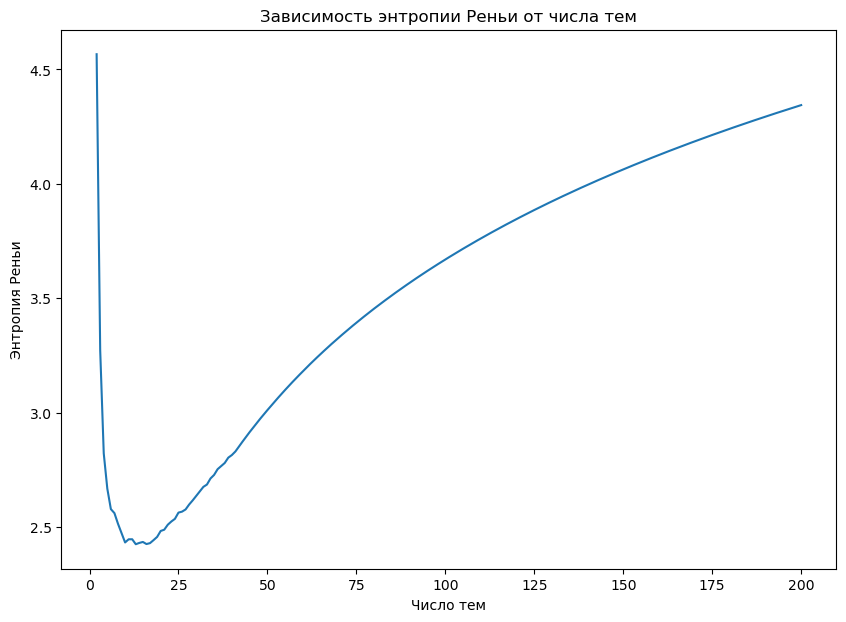

In [28]:
plt.figure(figsize=(10,7))
plt.plot(glob_clusters, glob_Renyi)
plt.title("Зависимость энтропии Реньи от числа тем")
plt.xlabel("Число тем")
plt.ylabel("Энтропия Реньи")
plt.show()

In [29]:
print(f"Минимальное значение энтропии Реньи ({min_Renyi}) было получено при числе тем {opt_topics_count}.")

Минимальное значение энтропии Реньи (2.4244478129258376) было получено при числе тем 13.


In [30]:
model = gibbslda.CGibbsLDA()
model.SetInputDocs(corpus)
model.SetParameters(alpha=0.1, beta=0.1, topics=opt_topics_count, niters=100, nitersave=100, ldamethod="embeddings", fixtopics=0, granwnd=0, out_dir=f"./data/{opt_topics_count}_topics/")
model.SetEmbeddings("./embeddings/words_in_docs.txt", emb_similars=30)
model.StartCalculation()

Documents count:  2553
Loading OK     
Calculating the Most Similar Words
Done. Words misses =  27433 / 68100
Iterations done:  100
    Documents ratio (Theta) =  21
    Words ratio (Phi) =  7


In [31]:
opt_topics = [f"Topic {i+1}" for i in range(opt_topics_count)]

In [32]:
Ф_opt_columns = ["Word"]
Ф_opt_columns.extend(opt_topics)
Ф_opt = pd.read_csv(f"./data/{opt_topics_count}_topics/phi100.csv", sep=";", encoding="UTF-8", index_col=False, names=Ф_opt_columns)
Ф_opt

,Word,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13
0,1988,0.00001,0.00003,0.00000,0.00000,0.00000,0.00002,0.00000,0.00013,0.00000,0.00000,0.00000,0.00001,0.00031
1,200,0.00017,0.00000,0.00036,0.00018,0.00000,0.00000,0.00045,0.00014,0.00010,0.00017,0.00006,0.00004,0.00005
2,2011,0.00004,0.00030,0.00000,0.00000,0.00000,0.00000,0.00014,0.00008,0.00000,0.00003,0.00010,0.00024,0.00000
3,2014,0.00005,0.00100,0.00000,0.00001,0.00007,0.00013,0.00002,0.00015,0.00000,0.00005,0.00004,0.00026,0.00033
4,2015,0.00009,0.00071,0.00000,0.00007,0.00001,0.00001,0.00000,0.00020,0.00000,0.00073,0.00000,0.00025,0.00042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68095,thawley,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00001,0.00000,0.00000,0.00000,0.00000
68096,transportable,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
68097,trashy,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
68098,vaccinecovid,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [33]:
Θ_opt_columns = ["Doc"]
Θ_opt_columns.extend(opt_topics)
Θ_opt = pd.read_csv(f"./data/{opt_topics_count}_topics/theta100.csv", sep=";", encoding="UTF-8", index_col=0, names=Θ_opt_columns)
Θ_opt

,Doc,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13
1,russia ha expelled dutch reporter newspaper ha...,0.00025,0.77661,0.00025,0.00025,0.00025,0.00025,0.02529,0.01528,0.04282,0.00025,0.00025,0.13048,0.00776
2,largest important event mathematical calendar ...,0.00033,0.00033,0.03660,0.00692,0.00033,0.07287,0.00033,0.15199,0.05638,0.00033,0.22123,0.00363,0.44873
3,earlier today set three question russian math ...,0.00025,0.00025,0.11402,0.00767,0.00025,0.09671,0.00025,0.11650,0.00025,0.00025,0.26985,0.01509,0.37868
4,labour ha asked conservative check party ha ma...,0.00228,0.04573,0.00021,0.00435,0.16987,0.00021,0.00021,0.00021,0.00021,0.00021,0.00021,0.77612,0.00021
5,russia ha hosted high profile international ta...,0.00022,0.24675,0.07066,0.00022,0.00242,0.00022,0.60775,0.00022,0.00022,0.00022,0.00022,0.07066,0.00022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2549,joan e greve senate leader chuck schumer ha an...,0.03295,0.01302,0.00003,0.86223,0.00003,0.00003,0.01332,0.00003,0.05801,0.00003,0.02026,0.00003,0.00003
2550,closing blog starting fresh australia ’ health...,0.00530,0.00003,0.71095,0.00003,0.00735,0.00003,0.00120,0.00032,0.27468,0.00003,0.00003,0.00003,0.00003
2551,’ launched new blog link – head latest hotel q...,0.00850,0.00850,0.79137,0.03362,0.04677,0.00003,0.00003,0.00003,0.04852,0.03421,0.00003,0.02836,0.00003
2552,liveblog ha closed coverage coronavirus pandem...,0.00708,0.03500,0.84245,0.02736,0.01472,0.00356,0.00003,0.00032,0.06555,0.00003,0.00385,0.00003,0.00003


### 4) определение топ-30 слов для каждой темы

In [78]:
Ф = Ф_opt[["Word", "Topic 1"]].sort_values(by='Topic 1', ascending=False)[:30]
Ф

,Word,Topic 1
237,’,0.02117
100,ha,0.01026
1409,price,0.01009
234,year,0.00854
220,uk,0.00794
2521,market,0.00757
130,month,0.00645
581,energy,0.00598
1566,supply,0.00533
19,also,0.00484


In [87]:
Ф = Ф_opt[["Word", "Topic 2"]].sort_values(by='Topic 2', ascending=False)[:30]
Ф

,Word,Topic 2
237,’,0.02540
185,said,0.01354
183,russia,0.01242
100,ha,0.01182
229,wa,0.01018
184,russian,0.00888
219,u,0.00826
166,putin,0.00794
770,china,0.00619
49,country,0.00509


In [88]:
Ф = Ф_opt[["Word", "Topic 3"]].sort_values(by='Topic 3', ascending=False)[:30]
Ф

,Word,Topic 3
185,said,0.01669
237,’,0.01613
1679,covid,0.01604
2895,vaccine,0.01528
100,ha,0.01306
1588,19,0.00991
49,country,0.00970
39,case,0.00914
881,people,0.00908
1750,health,0.00891


In [89]:
Ф = Ф_opt[["Word", "Topic 4"]].sort_values(by='Topic 4', ascending=False)[:30]
Ф

,Word,Topic 4
237,’,0.02647
1470,biden,0.01637
185,said,0.01379
3300,trump,0.01355
219,u,0.00948
667,president,0.00907
229,wa,0.00882
1063,house,0.00878
100,ha,0.00766
4026,republican,0.00718


In [90]:
Ф = Ф_opt[["Word", "Topic 5"]].sort_values(by='Topic 5', ascending=False)[:30]
Ф

,Word,Topic 5
237,’,0.02260
1151,say,0.01617
618,johnson,0.01456
229,wa,0.01384
100,ha,0.01253
220,uk,0.01236
96,government,0.01061
185,said,0.01019
126,minister,0.00948
232,would,0.00741


In [91]:
Ф = Ф_opt[["Word", "Topic 6"]].sort_values(by='Topic 6', ascending=False)[:30]
Ф

,Word,Topic 6
237,’,0.02881
3917,game,0.00878
5254,min,0.00832
1914,team,0.00819
229,wa,0.00783
2506,goal,0.00700
4971,england,0.00694
4253,player,0.00688
305,group,0.00599
4166,0,0.00590


In [92]:
Ф = Ф_opt[["Word", "Topic 7"]].sort_values(by='Topic 7', ascending=False)[:30]
Ф

,Word,Topic 7
219,u,0.01516
185,said,0.01426
237,’,0.01389
738,afghanistan,0.01264
930,taliban,0.01095
229,wa,0.00965
100,ha,0.00891
49,country,0.00879
737,afghan,0.00782
881,people,0.00722


In [93]:
Ф = Ф_opt[["Word", "Topic 8"]].sort_values(by='Topic 8', ascending=False)[:30]
Ф

,Word,Topic 8
237,’,0.04694
2502,final,0.01215
95,gold,0.01136
333,medal,0.01118
946,woman,0.01020
1097,men,0.00943
1914,team,0.00855
229,wa,0.00820
3917,game,0.00812
418,–,0.00675


In [94]:
Ф = Ф_opt[["Word", "Topic 9"]].sort_values(by='Topic 9', ascending=False)[:30]
Ф

,Word,Topic 9
237,’,0.02630
100,ha,0.01265
229,wa,0.00873
1627,australia,0.00802
185,said,0.00802
881,people,0.00716
96,government,0.00664
1679,covid,0.00571
865,new,0.00564
39,case,0.00531


In [95]:
Ф = Ф_opt[["Word", "Topic 10"]].sort_values(by='Topic 10', ascending=False)[:30]
Ф

,Word,Topic 10
1660,climate,0.01722
237,’,0.01261
49,country,0.01241
414,world,0.01074
185,said,0.00951
100,ha,0.00784
418,–,0.00777
3517,emission,0.00760
2505,global,0.00748
234,year,0.00596


In [96]:
Ф = Ф_opt[["Word", "Topic 11"]].sort_values(by='Topic 11', ascending=False)[:30]
Ф

,Word,Topic 11
237,’,0.06996
229,wa,0.01738
418,–,0.01011
100,ha,0.00952
320,like,0.00760
343,one,0.00748
1151,say,0.00700
482,time,0.00609
294,first,0.00589
194,set,0.00524


In [97]:
Ф = Ф_opt[["Word", "Topic 12"]].sort_values(by='Topic 12', ascending=False)[:30]
Ф

,Word,Topic 12
237,’,0.01927
229,wa,0.01438
418,–,0.00867
185,said,0.00767
100,ha,0.00758
546,company,0.00744
183,russia,0.00459
96,government,0.00438
7751,facebook,0.00412
343,one,0.00373


In [98]:
Ф = Ф_opt[["Word", "Topic 13"]].sort_values(by='Topic 13', ascending=False)[:30]
Ф

,Word,Topic 13
229,wa,0.01749
418,–,0.00769
234,year,0.00584
258,book,0.00502
865,new,0.00399
1043,film,0.00392
343,one,0.00375
1085,life,0.00332
414,world,0.00320
183,russia,0.00301
